In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

Different combinations of $(X, Y)$ to evaluate the approximation methods

In [2]:
X = np.random.exponential(size=40)[:, None]
#Y = np.random.chisquare(5, size=1000)[:, None]
#X = np.random.randn(40)[:, None]
Y = (np.random.randn(40)+20)[:, None]

Show quickly the distributions.

(array([13.,  9.,  9.,  4.,  1.,  2.,  1.,  0.,  0.,  1.]),
 array([0.00696522, 0.34892109, 0.69087696, 1.03283283, 1.3747887 ,
        1.71674457, 2.05870044, 2.40065631, 2.74261218, 3.08456805,
        3.42652392]),
 <a list of 10 Patch objects>)

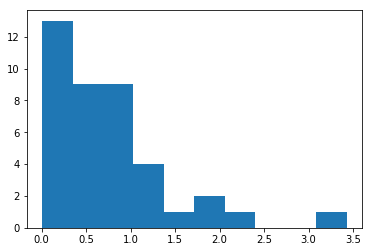

In [3]:
plt.hist(X, bins=10)

(array([2., 1., 2., 7., 4., 7., 9., 2., 3., 3.]),
 array([18.22480662, 18.61529586, 19.0057851 , 19.39627434, 19.78676358,
        20.17725282, 20.56774206, 20.95823129, 21.34872053, 21.73920977,
        22.12969901]),
 <a list of 10 Patch objects>)

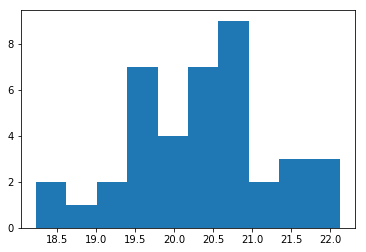

In [4]:
plt.hist(Y, bins=10)

### Auxiliary functions

In [27]:
def H(X):
    m = X.shape[0]
    return np.identity(m) - (1/m) * (np.ones((m, m)))

# aggregate two samples
def agg_sample(X,Y):
    return np.array(list(X) + list(Y)).reshape(-1, 1)

# compute median
def median(X,Y):   
    distances = metrics.pairwise_distances(agg_sample(X,Y))    # distances in m x m matrix
    return np.median(distances)

# Gaussian kernel
def k(X, Y):
    sigma = median(X,Y)
    return metrics.pairwise.rbf_kernel(X.reshape(-1, 1), Y.reshape(-1, 1), gamma=1/(sigma**2))

# Biased MMD

First, we compute the biased MMD to have a measure how different the two distributions $P_X$ and $P_Y$ are in the RKHS.

In [32]:
# biased MMD estimator
def MMD_b(X,Y):
    Kx = k(X,X)
    Ky = k(Y,Y)
    m = X.shape[0]
    return (1/m**2) * np.trace(Kx @ H(X) @ Ky @ H(X))

In [33]:
MMD_b(X, Y)

0.009890865354491732

# Unbiased MMD
Next, we compute the MMD with bias correction.

In [19]:
# unbiased MMD estimator
def MMD_u(X,Y):
    return np.sqrt( 1/(m*(m-1)) * (np.matrix(k(X,X)).sum() + np.matrix(k(Y,Y)).sum() - 2 * np.matrix(k(X,Y)).sum()))

In [20]:
MMD_u(X, Y)

0.9268660512612373

# HSIC with Gamma approximation

$\mathcal{H}_0 : P_{XY} = P_X P_Y$ is a complex distribution and must be approximated. Here, we approximate it by a Gamma distribution with parameters $\alpha$ (`al`) and $\beta$ (`beta`).

In [12]:
from scipy.stats import gamma

In [36]:
def HSIC_gamma(X,Y,alpha):
    
    Kx = k(X,X)
    Ky = k(Y,Y)
    
    m = X.shape[0]
    
    # c for centred Gram matrices
    Kx_c = H(X) @ Kx @ H(X)    
    Ky_c = H(X) @ Ky @ H(X)
    
    # test statistic
    stat = (1/m) * (Kx_c.T @ Ky_c).sum()
    
    mX = 1/(m*(m-1)) * (np.ones((m,1)).T @ Kx @ np.ones((m,1)))
    mY = 1/(m*(m-1)) * (np.ones((m,1)).T @ Ky @ np.ones((m,1)))
    
    varHSIC = (1/6 * (Kx_c.T @ Ky_c))**2
    varHSIC = 1/(m*(m-1)) * (np.sum(varHSIC) - np.trace(varHSIC))
    varHSIC = varHSIC * 72 * (m-4) * (m-5) / (m*(m-1)*(m-2)*(m-3))
    
    mHSIC = 1/m * (1 + mX * mY - mX - mY)
    
    # Gamma distribution parameters
    al = mHSIC**2 / varHSIC
    beta = m*varHSIC / mHSIC
    
    # 1-alpha threshold
    threshold = gamma.ppf(1-alpha, al, scale=beta)[0][0]
    
    if stat > threshold:
        print('H0 rejected')
    else:
        print('H0 accepted')
    
    return (stat, threshold)

In [37]:
# test level alpha = 0.05
print('p-value:', HSIC_gamma(X,Y,0.05)[0])
print('test threshold:', HSIC_gamma(X,Y,0.05)[1])

H0 accepted
p-value: 4.3021142204224816e-16
H0 accepted
test threshold: 1.780345481791046


# dHSIC
$\mathcal{H}_0 : P_{\boldsymbol{X}} = P_{X_1} P_{X_2} P_{X_3} ... P_{X_d} $ must also be approximated.

In [38]:
# generate 50 random variables with m measurements each
X = np.random.randn(10000).reshape(50,-1)

In [39]:
def dHSIC(X):
    K = {}
    
    # number of random variables d and measurements m
    d, m = X.shape
    
    for j in range(d):
        K[j] = metrics.pairwise.rbf_kernel(X[j].reshape(-1,1))    # m x m matrix

    term1 = np.ones((m,m))
    term2 = 1
    term3 = np.full((1,m), 2/m)

    for j in range(d):
        term1 = term1 @ K[j]
        term2 = 1/(m**2) * term2 * K[j].sum()
        term3 = 1/m * term3 * K[j].sum(axis=0)
    
    return 1/(m**2) * term1.sum() + term2 - term3.sum()

In [40]:
# joint independence between 50 random normal distributions with m measurements each
dHSIC(X)

7.395038771939209e+97